In [1]:
import pandas as pd
import sys

from transformers import AutoTokenizer
from datasets import load_dataset

sys.path.append('../')

from src.preprocessing import DataPreprocessor, FEATURES, PAD_FEATURE_VEC, BOUNDARY_FEATURE_VEC, UNK_FEATURE_VEC, MISMATCH_MAP, create_phoneme_map
from src.config import DataPreprocessingParams, TransformerSegmentationConfig, DatasetParams

In [2]:
phoible = pd.read_csv('../data/phoible.csv', sep=',', encoding='utf-8')

/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_20068/1109117776.py:1: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv('../data/phoible.csv', sep=',', encoding='utf-8')


In [3]:
tokenizer = AutoTokenizer.from_pretrained('transformersegmentation/CHILDES-Tokenizer')

In [4]:
dataset_params = DatasetParams(subconfig='french', name='transformersegmentation/CHILDES')
data_processing_params = DataPreprocessingParams(max_input_length=64, join_utts=False, map_phones_to_features=True)

In [5]:
phoneme_map = create_phoneme_map(tokenizer, 'French', '../data/phoible.csv')

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CharTransformers/TransformerSegmentation/notebooks


/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CharTransformers/TransformerSegmentation/notebooks/../src/preprocessing.py:35: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv(phoible_data_path)


In [6]:

dataset = load_dataset(dataset_params.name, dataset_params.subconfig, split='train')
data_preprocessor = DataPreprocessor(data_processing_params, tokenizer)
dataset = dataset.map(data_preprocessor, batched=True, remove_columns=['text'])
dataset

Found cached dataset childes (/Users/zebulongoriely/.cache/huggingface/datasets/transformersegmentation___childes/french/1.0.0/c1a2022b0fe6c73568543b5d30ee329425ac03b8b9f3d320d1fcc49917af66f1)
Loading cached processed dataset at /Users/zebulongoriely/.cache/huggingface/datasets/transformersegmentation___childes/french/1.0.0/c1a2022b0fe6c73568543b5d30ee329425ac03b8b9f3d320d1fcc49917af66f1/cache-03b1f2a1fdbb97a0.arrow


Dataset({
    features: ['input_ids', 'attention_mask', 'word_starts'],
    num_rows: 117900
})

In [7]:
num_phonemes = 0
num_converted_phonemes = 0
phoneme_count = {}
for i in range(dataset.num_rows):
    utt = dataset[i]['input_ids']
    for j, phoneme in enumerate(utt):
        if phoneme < 6:
            continue
        num_phonemes += 1
        if phoneme not in phoneme_count:
            phoneme_count[phoneme] = 1
        else:
            phoneme_count[phoneme] += 1
        if phoneme_map[phoneme][-1] != 2:
            num_converted_phonemes += 1

print(f'Number of phonemes: {num_phonemes}')
print(f'Number of converted phonemes: {num_converted_phonemes}')
print(f'Percentage of converted phonemes: {num_converted_phonemes / num_phonemes * 100}%')

Number of phonemes: 1374168
Number of converted phonemes: 1372225
Percentage of converted phonemes: 99.8586053524751%


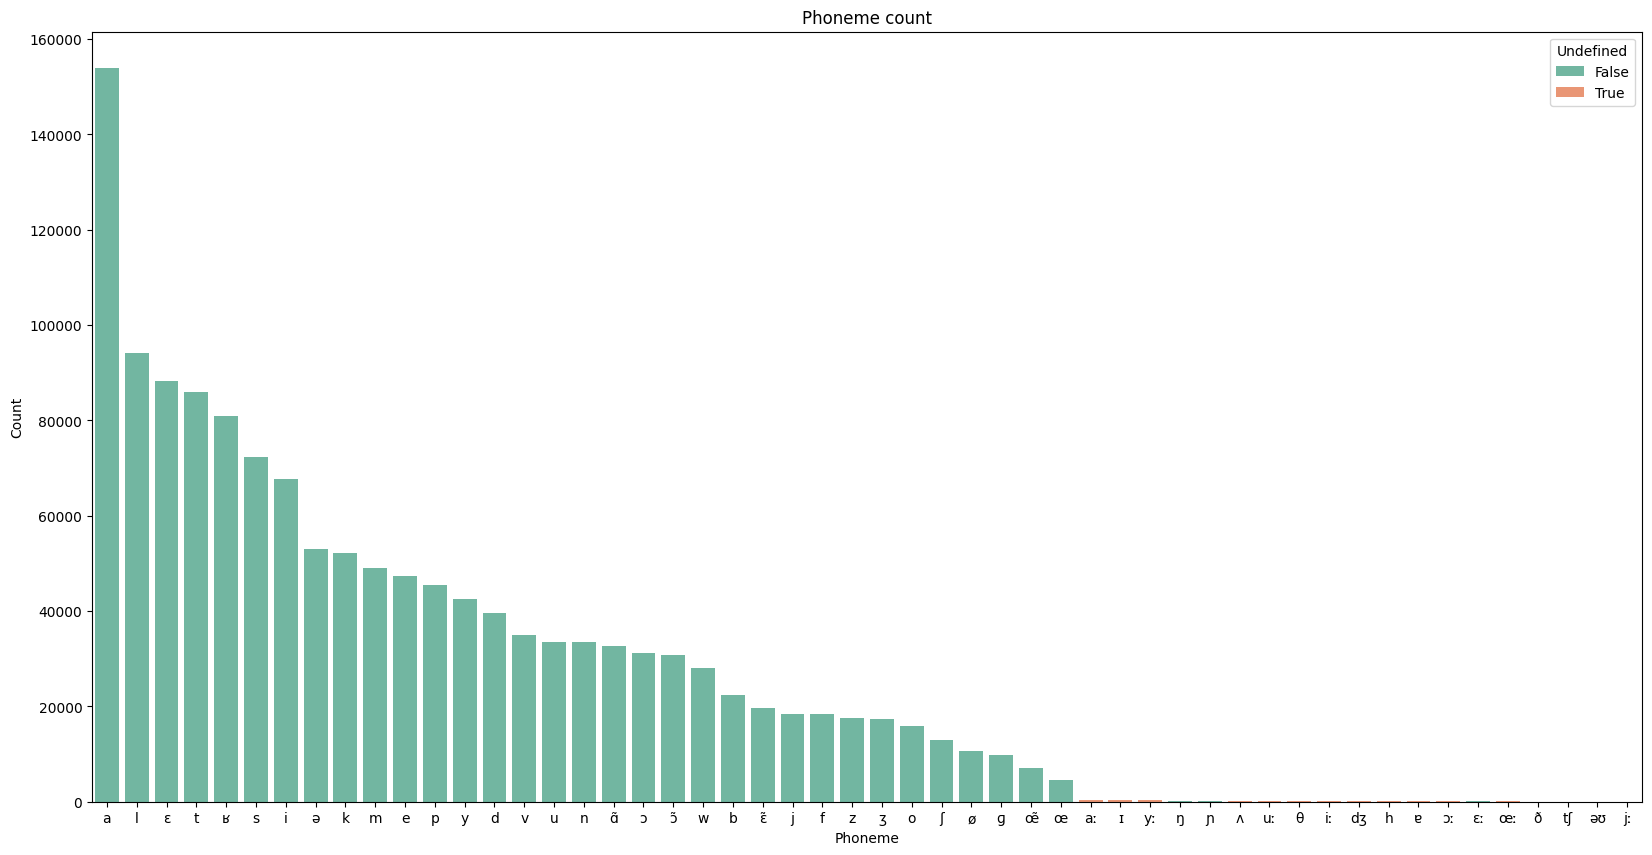

In [8]:
import matplotlib.pyplot as plt
import seaborn

plt.figure(figsize=(20, 10))
plt_data = pd.DataFrame(phoneme_count.items(), columns=['ID', 'Count'])
plt_data['Phoneme'] = plt_data['ID'].map(tokenizer.decode)
plt_data['Undefined'] = plt_data['ID'].map(lambda x: phoneme_map[x] in [PAD_FEATURE_VEC, BOUNDARY_FEATURE_VEC, UNK_FEATURE_VEC])
plt_data = plt_data.sort_values(by='Count', ascending=False)
seaborn.barplot(x='Phoneme', y='Count', data=plt_data, hue='Undefined', dodge=False, palette='Set2')

plt.xlabel('Phoneme')
plt.ylabel('Count')
plt.title('Phoneme count')

plt.show()


Text(0.5, 1.0, 'Feature vectors')

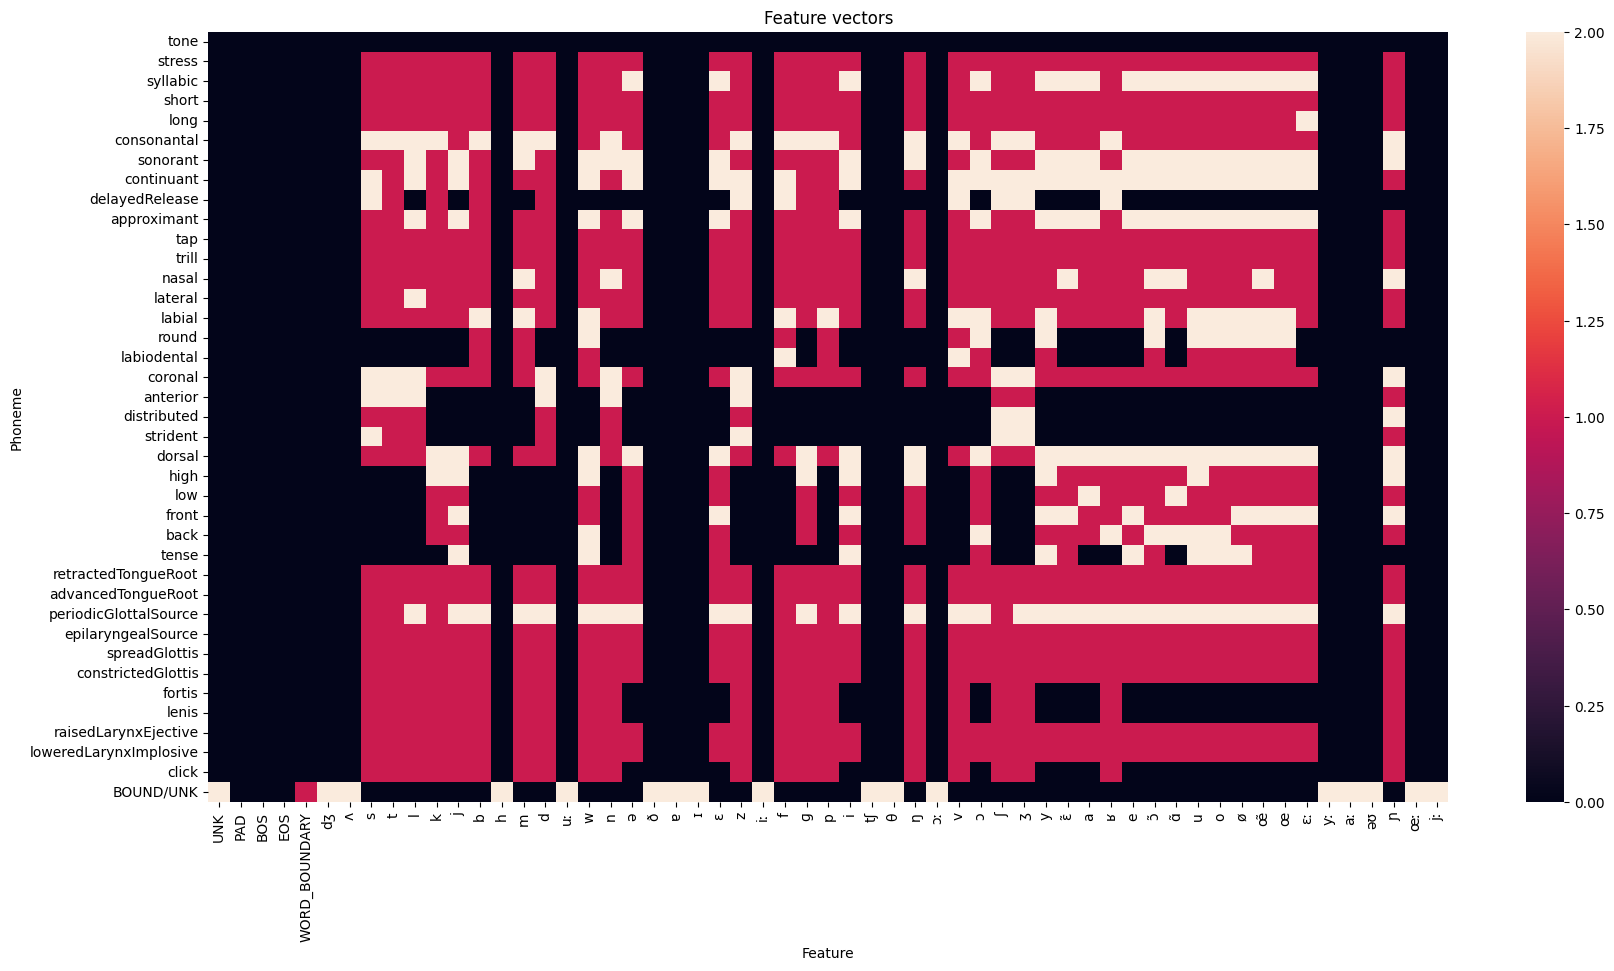

In [9]:
# Visualise feature vectors
import numpy as np
phoneme_ids = tokenizer.vocab.values()
phoneme_features = [phoneme_map[id] for id in phoneme_ids]
counts = [phoneme_count[id] if id in phoneme_count else 0 for id in phoneme_ids]
plt_data = pd.DataFrame({'ID' : phoneme_ids, 'Features' : phoneme_features, 'Phoneme' : tokenizer.vocab.keys(), 'Count' : counts})
plt_data = plt_data.sort_values(by='ID')

# Remove phonemes that have a count of less than 10
plt_data = plt_data[(plt_data['ID'] < 5) | (plt_data['Count'] > 10)]
plt_data = plt_data.set_index('ID')

# Set features to individual columns
for i in range(len(FEATURES)):
    plt_data[FEATURES[i]] = plt_data['Features'].map(lambda x: x[i])
plt_data['BOUNDARY/PAD'] = plt_data['Features'].map(lambda x: x[-1])

# Plot heatmap of feature vectors
plt.figure(figsize=(20, 10))
# seaborn.heatmap(plt_data, cmap='binary', cbar=False, xticklabels=FEATURES + ['BOUND/UNK'], yticklabels=list(plt_data['Phoneme']))
seaborn.heatmap(plt_data.drop(columns=['Features', 'Phoneme', 'Count']).T, yticklabels=FEATURES + ['BOUND/UNK'], xticklabels=plt_data['Phoneme'])
plt.xlabel('Feature')
plt.ylabel('Phoneme')
plt.title('Feature vectors')



In [10]:
american_phonemes = phoible[phoible['LanguageName'] == 'American English'].Phoneme.unique()
british_phonemes = phoible[phoible['LanguageName'] == 'English'].Phoneme.unique()

print (len(american_phonemes), len(british_phonemes))
    

39 64


In [11]:
# Get phonemes undefined in phoneme map
undefined_phonemes = []
for phoneme, count in phoneme_count.items():
    if phoneme_map[phoneme] is None:
        undefined_phonemes.append(tokenizer.convert_ids_to_tokens(phoneme))
undefined_phonemes

[]

# GPT2 Feature Model

In [12]:
from transformers import GPT2Config

from src.models.gpt2 import GPT2FeatureModel

In [13]:
config = GPT2Config(vocab_size=tokenizer.vocab_size, n_layer=2, n_head=4, n_embd=64, n_positions=128, n_inner=128)
model = GPT2FeatureModel(config, feature_size=len(FEATURES) + 1, feature_map=phoneme_map)

TypeError: __init__() got an unexpected keyword argument 'feature_size'

In [ ]:
model

GPT2FeatureModel(
  (custom_embedding): CustomLinear(in_features=39, out_features=64, bias=True)
  (embedding_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (transformer): GPT2Model(
    (wte): Embedding(89, 64)
    (wpe): Embedding(128, 64)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=64, out_f

In [ ]:
import torch

input_ids = torch.tensor(dataset['input_ids'][0])
attention_mask = torch.tensor(dataset['attention_mask'][0])
labels = torch.tensor(dataset['input_ids'][0])

model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

CausalLMOutputWithCrossAttentions(loss=tensor(0.0416, grad_fn=<MseLossBackward0>), logits=tensor([[[-0.2567,  0.0812, -0.0816,  ..., -0.0404,  0.1483,  0.0901],
         [-0.2111, -0.2524,  0.0235,  ...,  0.0181,  0.3019,  1.2142],
         [-0.2691, -0.2566,  0.1771,  ..., -0.0447,  0.1989,  1.2004],
         ...,
         [-0.3365, -0.1812,  0.1638,  ..., -0.0342,  0.1589,  1.2534],
         [-0.2273, -0.2762,  0.0490,  ...,  0.0519,  0.3241,  1.2332],
         [-0.2744, -0.2085,  0.1815,  ...,  0.0696,  0.2251,  1.2482]]],
       grad_fn=<ViewBackward0>), past_key_values=((tensor([[[[ 0.0296, -0.0320,  0.1101,  ...,  0.0065,  0.0046, -0.0232],
          [-0.0178,  0.1834,  0.2099,  ...,  0.1618, -0.4227,  0.1569],
          [ 0.0045,  0.1322,  0.2144,  ...,  0.1292, -0.3870,  0.0308],
          ...,
          [ 0.0064,  0.1344,  0.1992,  ...,  0.1909, -0.4147,  0.0642],
          [ 0.0079,  0.0685,  0.1433,  ...,  0.1808, -0.2929,  0.1402],
          [ 0.0089,  0.0718,  0.2442,  ...